## 0 - Config + folders

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

RANDOM_STATE = 42

PAIRS = ["EN<->ES", "EN<->IT", "EN<->PT"]

PAIR_TO_PATH = {
    "EN<->ES": Path("final_en_es_2.csv"),
    "EN<->IT": Path("final_en_it_2.csv"),
    "EN<->PT": Path("final_en_pt_2.csv"),
}

OUT_DIR = Path("rq3_outputs")
DIRS = {
    "results": OUT_DIR / "results",
    "plots": OUT_DIR / "plots",
    "tables": OUT_DIR / "tables",
    "shap": OUT_DIR / "shap",
    "examples": OUT_DIR / "examples",
}
for d in DIRS.values():
    d.mkdir(parents=True, exist_ok=True)

N_EXTREMES = 20  

print("RQ3 config:")
print(" - PAIRS:", PAIRS)
print(" - OUT_DIR:", OUT_DIR.resolve())
print(" - N_EXTREMES:", N_EXTREMES)


RQ3 config:
 - PAIRS: ['EN<->ES', 'EN<->IT', 'EN<->PT']
 - OUT_DIR: C:\Users\paolo\OneDrive - Tilburg University\S2. Thesis\DUOLINWORK\rq3_outputs
 - N_EXTREMES: 20


## 1 - Imports + helper utilities

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor


import shap

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_metrics(y_true, y_pred):
    return {
        "rmse": rmse(y_true, y_pred),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2":  float(r2_score(y_true, y_pred)),
    }

def _is_cat(series: pd.Series) -> bool:
    return series.dtype == "object" or str(series.dtype).startswith("category")

def make_preprocessor_ohe_scale(dfX: pd.DataFrame):
    cat_cols = [c for c in dfX.columns if _is_cat(dfX[c])]
    num_cols = [c for c in dfX.columns if c not in cat_cols]

    num_pipe = Pipeline([("scaler", StandardScaler())])
    cat_pipe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
    )
    return pre

def safe_to_dense(X):
    """Convert sparse matrices to dense numpy arrays when needed."""
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

def find_first_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 - Load datasets

In [3]:
def load_pair(pair: str) -> pd.DataFrame:
    p = PAIR_TO_PATH[pair]
    if not p.exists():
        raise FileNotFoundError(f"Missing file for {pair}: {p.resolve()}")
    df = pd.read_csv(p)
    return df

dfs = {}
for pair in PAIRS:
    df = load_pair(pair)
    dfs[pair] = df
    print(pair, "shape:", df.shape)
    for col in ["row_id", "src_median_hf_days", "tgt_median_hf_days", "src_pos", "tgt_pos", "semantic_field"]:
        print("  -", col, "OK" if col in df.columns else "MISSING")


EN<->ES shape: (1322, 19)
  - row_id MISSING
  - src_median_hf_days OK
  - tgt_median_hf_days OK
  - src_pos OK
  - tgt_pos OK
  - semantic_field OK
EN<->IT shape: (955, 19)
  - row_id MISSING
  - src_median_hf_days OK
  - tgt_median_hf_days OK
  - src_pos OK
  - tgt_pos OK
  - semantic_field OK
EN<->PT shape: (1138, 19)
  - row_id MISSING
  - src_median_hf_days OK
  - tgt_median_hf_days OK
  - src_pos OK
  - tgt_pos OK
  - semantic_field OK


## 3 - Construct RQ3 targets: asymmetry (signed) + descriptive plots

{'pair': 'EN<->ES', 'n': 1322, 'asym_mean': -1.0095777122556067, 'asym_median': -0.7710973282579374, 'asym_std': 2.175536053646951, 'pct_src_harder': 0.28290468986384265}


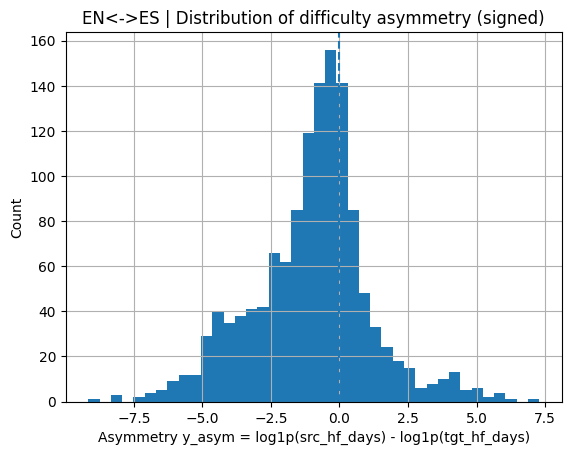

{'pair': 'EN<->IT', 'n': 955, 'asym_mean': 0.8119852195643936, 'asym_median': 0.891709324474733, 'asym_std': 2.799428616845191, 'pct_src_harder': 0.6659685863874345}


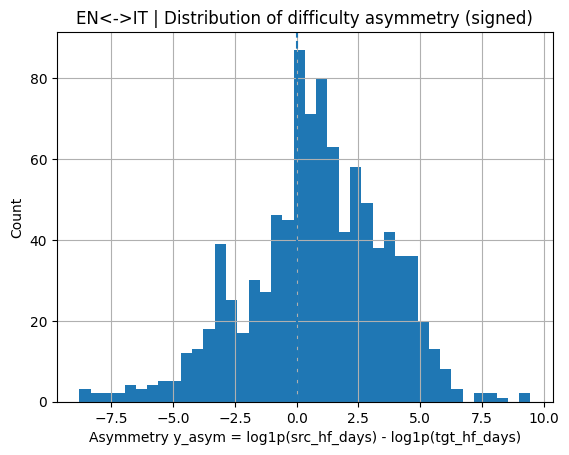

{'pair': 'EN<->PT', 'n': 1138, 'asym_mean': 0.28168928842465346, 'asym_median': 0.110815435384918, 'asym_std': 3.1583766263575006, 'pct_src_harder': 0.5281195079086116}


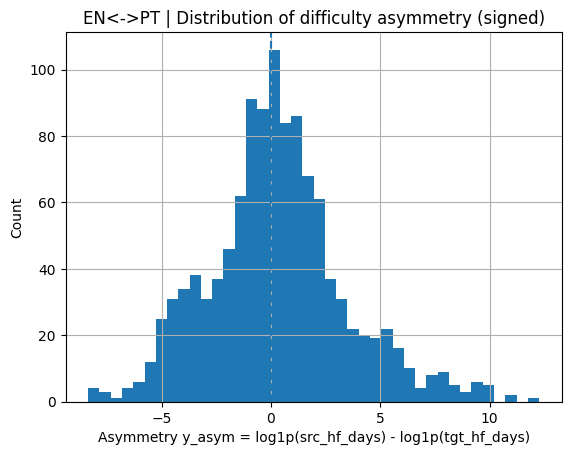

,pair,n,asym_mean,asym_median,asym_std,pct_src_harder
0,EN<->ES,1322,-1.009578,-0.771097,2.175536,0.282905
1,EN<->IT,955,0.811985,0.891709,2.799429,0.665969
2,EN<->PT,1138,0.281689,0.110815,3.158377,0.528120


In [4]:
TARGET_SRC = "src_median_hf_days"
TARGET_TGT = "tgt_median_hf_days"

rq3_targets = {}  

for pair, df in dfs.items():
    if TARGET_SRC not in df.columns or TARGET_TGT not in df.columns:
        raise ValueError(f"{pair}: missing target columns {TARGET_SRC}/{TARGET_TGT}")

    y_src = np.log1p(df[TARGET_SRC].to_numpy(dtype=float))
    y_tgt = np.log1p(df[TARGET_TGT].to_numpy(dtype=float))
    y_asym = y_src - y_tgt

    tmp = df.copy()
    tmp["y_src_log1p"] = y_src
    tmp["y_tgt_log1p"] = y_tgt
    tmp["y_asym"] = y_asym
    tmp["asym_dir"] = np.where(tmp["y_asym"] > 0, "src_harder", "tgt_harder")

    rq3_targets[pair] = tmp

    stats = {
        "pair": pair,
        "n": len(tmp),
        "asym_mean": float(tmp["y_asym"].mean()),
        "asym_median": float(tmp["y_asym"].median()),
        "asym_std": float(tmp["y_asym"].std()),
        "pct_src_harder": float((tmp["asym_dir"] == "src_harder").mean()),
    }
    print(stats)

    
    plt.figure()
    plt.hist(tmp["y_asym"], bins=40)
    plt.axvline(0, linestyle="--")
    plt.xlabel("Asymmetry y_asym = log1p(src_hf_days) - log1p(tgt_hf_days)")
    plt.ylabel("Count")
    plt.title(f"{pair} | Distribution of difficulty asymmetry (signed)")
    plt.grid(True)
    out_plot = DIRS["plots"] / f"asym_hist_{pair.replace('<->','_')}.png"
    plt.savefig(out_plot, bbox_inches="tight")
    plt.show()


stats_rows = []
for pair, tmp in rq3_targets.items():
    stats_rows.append({
        "pair": pair,
        "n": len(tmp),
        "asym_mean": float(tmp["y_asym"].mean()),
        "asym_median": float(tmp["y_asym"].median()),
        "asym_std": float(tmp["y_asym"].std()),
        "pct_src_harder": float((tmp["asym_dir"] == "src_harder").mean()),
    })
asym_stats_df = pd.DataFrame(stats_rows)
asym_stats_df.to_csv(DIRS["tables"] / "rq3_asymmetry_descriptives.csv", index=False)
display(asym_stats_df)


## 4 - Feature design for RQ3

In [5]:
CONFLICT_COLS = ["meaning_conflicts", "grammatical_conflicts"]

def normalize_conflict_cols(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()
    for c in CONFLICT_COLS:
        if c not in df.columns:
            continue

        s = df[c]

        
        if str(s.dtype).startswith("bool"):
            df[c] = s.astype(int)
            continue

        
        if pd.api.types.is_numeric_dtype(s):
            
            df[c] = s.fillna(0)
            continue

        
        df[c] = s.astype(str).fillna("missing").astype("category")

    return df

def add_contrast_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    pairs = [
        ("src_lemma_length",  "tgt_lemma_length",  "diff_len"),
        ("src_session_count", "tgt_session_count", "diff_sessions"),
        ("src_lexeme_count",  "tgt_lexeme_count",  "diff_lexeme_count"),
    ]

    for a, b, name in pairs:
        if a in df.columns and b in df.columns:
            aa = pd.to_numeric(df[a], errors="coerce")
            bb = pd.to_numeric(df[b], errors="coerce")
            df[name] = aa - bb
            df[f"abs_{name}"] = df[name].abs()

    return df



NUMERIC_COLS = [
    "frequency", "concreteness",
    "src_lemma_length", "tgt_lemma_length",
    "src_session_count", "tgt_session_count",
    "src_lexeme_count", "tgt_lexeme_count",

    
    "src_median_hf", "tgt_median_hf",
    "src_median_hf_days", "tgt_median_hf_days",
]


def coerce_numeric_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in NUMERIC_COLS:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df




def build_feature_frame(pair_df: pd.DataFrame) -> pd.DataFrame:
    df = pair_df.copy()
    df = coerce_numeric_cols(df)          
    df = normalize_conflict_cols(df)      
    df = add_contrast_features(df)
    return df


rq3_data = {}
for pair, tmp in rq3_targets.items():
    df = build_feature_frame(tmp)

    
    rq3_data[pair] = df

    print(pair, "prepared columns:", len(df.columns))
    missing_conf = [c for c in CONFLICT_COLS if c not in df.columns]
    if missing_conf:
        print("  WARNING missing conflict cols:", missing_conf)




EN<->ES prepared columns: 29
EN<->IT prepared columns: 29
EN<->PT prepared columns: 29


## 5 - Train/test split (stratify by asym_dir to balance directions in test)

In [6]:
rq3_splits = {}
for pair, df in rq3_data.items():
    idx = np.arange(len(df))
    strat = df["asym_dir"] if "asym_dir" in df.columns else None

    train_idx, test_idx = train_test_split(
        idx,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=strat,
    )
    rq3_splits[pair] = {"train_idx": train_idx, "test_idx": test_idx}

    print(pair, "train:", len(train_idx), "test:", len(test_idx))
    print("  train src_harder %:", float((df.iloc[train_idx]["asym_dir"] == "src_harder").mean()))
    print("  test  src_harder %:", float((df.iloc[test_idx]["asym_dir"] == "src_harder").mean()))


EN<->ES train: 1057 test: 265
  train src_harder %: 0.282876064333018
  test  src_harder %: 0.2830188679245283
EN<->IT train: 764 test: 191
  train src_harder %: 0.6662303664921466
  test  src_harder %: 0.6649214659685864
EN<->PT train: 910 test: 228
  train src_harder %: 0.5285714285714286
  test  src_harder %: 0.5263157894736842


## 6 - Build final feature matrix definition

In [7]:
EXCLUDE_COLS = {
    
    "row_id",
    "src_lemma", "tgt_lemma",

    
    "src_median_hf", "tgt_median_hf",
    TARGET_SRC, TARGET_TGT,   

    
    "y_src_log1p", "y_tgt_log1p",
    "y_asym", "asym_dir",
}


def get_feature_cols(df: pd.DataFrame):
    return [c for c in df.columns if c not in EXCLUDE_COLS]

feature_cols_by_pair = {}
for pair, df in rq3_data.items():
    feat_cols = get_feature_cols(df)

    
    bad_cols = df[feat_cols].columns[df[feat_cols].isna().any()].tolist()
    feat_cols = [c for c in feat_cols if c not in bad_cols]

    feature_cols_by_pair[pair] = feat_cols

    print(pair, "n_features:", len(feat_cols), "| dropped_na_cols:", len(bad_cols))
    if bad_cols:
        print("  dropped:", bad_cols[:15], "..." if len(bad_cols) > 15 else "")



FORBIDDEN = {"src_lemma", "tgt_lemma", "src_median_hf", "tgt_median_hf", TARGET_SRC, TARGET_TGT}
for pair, cols in feature_cols_by_pair.items():
    bad = sorted(set(cols).intersection(FORBIDDEN))
    if bad:
        raise ValueError(f"{pair}: forbidden features still present in model features: {bad}")


schema_rows = []
for pair, cols in feature_cols_by_pair.items():
    for c in cols:
        schema_rows.append({"pair": pair, "feature": c})
schema_df = pd.DataFrame(schema_rows)
schema_df.to_csv(DIRS["tables"] / "rq3_feature_schema.csv", index=False)
display(schema_df.head(20))


EN<->ES n_features: 19 | dropped_na_cols: 0
EN<->IT n_features: 19 | dropped_na_cols: 0
EN<->PT n_features: 19 | dropped_na_cols: 0


,pair,feature
0,EN<->ES,src_pos
1,EN<->ES,tgt_pos
2,EN<->ES,src_lexeme_count
3,EN<->ES,tgt_lexeme_count
4,EN<->ES,grammatical_conflicts
5,EN<->ES,meaning_conflicts
6,EN<->ES,src_lemma_length
7,EN<->ES,tgt_lemma_length
8,EN<->ES,concreteness
9,EN<->ES,frequency


## 7 - Ridge trained on asymmetry

In [8]:
ridge_results = []
coef_tables = {}

for pair, df in rq3_data.items():
    train_idx = rq3_splits[pair]["train_idx"]
    test_idx  = rq3_splits[pair]["test_idx"]

    feat_cols = feature_cols_by_pair[pair]

    X_train = df.iloc[train_idx][feat_cols].copy()
    X_test  = df.iloc[test_idx][feat_cols].copy()
    y_train = df.iloc[train_idx]["y_asym"].to_numpy(dtype=float)
    y_test  = df.iloc[test_idx]["y_asym"].to_numpy(dtype=float)

    pre = make_preprocessor_ohe_scale(X_train)

    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)

    pipe = Pipeline([("pre", pre), ("model", ridge)])
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)

    m = eval_metrics(y_test, yhat)
    ridge_results.append({
        "pair": pair,
        **{f"test_{k}": v for k, v in m.items()},
    })

    
    pre_fitted = pipe.named_steps["pre"]
    feature_names = pre_fitted.get_feature_names_out()

    coefs = pipe.named_steps["model"].coef_
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

    coef_tables[pair] = coef_df

    out_path = DIRS["tables"] / f"coef_asym_ridge_{pair.replace('<->','_')}.csv"
    coef_df.to_csv(out_path, index=False)

    
    print("\n==============================")
    print(pair, "| Ridge coefficients on asymmetry (y_asym)")
    print("Sanity metrics:", m)
    print("\nTop 20 positive coefs (push src harder):")
    display(coef_df.sort_values("coef", ascending=False).head(20))
    print("\nTop 20 negative coefs (push tgt harder):")
    display(coef_df.sort_values("coef", ascending=True).head(20))

ridge_results_df = pd.DataFrame(ridge_results)
ridge_results_df.to_csv(DIRS["results"] / "ridge_asym_sanity_metrics.csv", index=False)
display(ridge_results_df)



EN<->ES | Ridge coefficients on asymmetry (y_asym)
Sanity metrics: {'rmse': 2.1529933560665127, 'mae': 1.6246378756776174, 'r2': 0.0944013916105968}

Top 20 positive coefs (push src harder):


,feature,coef,abs_coef
0,cat__semantic_field_feeling,2.493110,2.493110
2,cat__semantic_field_stative,1.258112,1.258112
3,cat__tgt_pos_prep,1.176769,1.176769
5,cat__semantic_field_Tops,1.116210,1.116210
6,cat__semantic_field_pert,0.952735,0.952735
9,cat__src_pos_adv,0.892551,0.892551
11,cat__semantic_field_object,0.845901,0.845901
14,cat__semantic_field_phenomenon,0.676750,0.676750
17,cat__semantic_field_perception,0.629663,0.629663
21,cat__semantic_field_location,0.477127,0.477127



Top 20 negative coefs (push tgt harder):


,feature,coef,abs_coef
1,cat__semantic_field_time,-1.853041,1.853041
4,cat__semantic_field_attribute,-1.118503,1.118503
7,cat__semantic_field_food,-0.950918,0.950918
8,cat__semantic_field_event,-0.898679,0.898679
10,cat__tgt_pos_conj,-0.855834,0.855834
12,cat__semantic_field_contact,-0.826091,0.826091
13,cat__semantic_field_person,-0.788010,0.788010
15,cat__semantic_field_animal,-0.661093,0.661093
16,cat__semantic_field_shape,-0.638642,0.638642
18,cat__tgt_pos_verb,-0.574673,0.574673



EN<->IT | Ridge coefficients on asymmetry (y_asym)
Sanity metrics: {'rmse': 2.9681896118596924, 'mae': 2.3283357894715295, 'r2': 0.06955143678100417}

Top 20 positive coefs (push src harder):


,feature,coef,abs_coef
3,cat__semantic_field_feeling,1.758962,1.758962
4,cat__tgt_pos_det,1.613467,1.613467
7,cat__semantic_field_process,1.419672,1.419672
9,cat__semantic_field_plant,1.163403,1.163403
11,cat__semantic_field_motive,1.005019,1.005019
12,cat__semantic_field_quantity,0.985501,0.985501
13,cat__semantic_field_competition,0.984522,0.984522
14,cat__semantic_field_artifact,0.943471,0.943471
15,cat__src_pos_adj,0.923137,0.923137
17,cat__src_pos_conj,0.847155,0.847155



Top 20 negative coefs (push tgt harder):


,feature,coef,abs_coef
0,cat__semantic_field_body,-2.099018,2.099018
1,cat__semantic_field_possession,-1.996984,1.996984
2,cat__src_pos_det,-1.901904,1.901904
5,cat__semantic_field_consumption,-1.574373,1.574373
6,cat__tgt_pos_prep,-1.566690,1.566690
8,cat__semantic_field_attribute,-1.348916,1.348916
10,cat__src_pos_pron,-1.114546,1.114546
19,cat__semantic_field_communication,-0.810198,0.810198
25,cat__tgt_pos_noun,-0.647894,0.647894
26,cat__semantic_field_contact,-0.641341,0.641341



EN<->PT | Ridge coefficients on asymmetry (y_asym)
Sanity metrics: {'rmse': 3.015381971150383, 'mae': 2.2916188734620184, 'r2': -0.030795714265903662}

Top 20 positive coefs (push src harder):


,feature,coef,abs_coef
0,cat__semantic_field_relation,2.701664,2.701664
1,cat__semantic_field_feeling,2.490951,2.490951
8,cat__semantic_field_emotion,1.465043,1.465043
9,cat__semantic_field_object,1.386974,1.386974
10,cat__tgt_pos_prep,1.367814,1.367814
13,cat__src_pos_adj,0.986711,0.986711
14,cat__semantic_field_motion,0.977587,0.977587
15,cat__semantic_field_location,0.927376,0.927376
17,cat__semantic_field_stative,0.891799,0.891799
19,cat__semantic_field_phenomenon,0.861810,0.861810



Top 20 negative coefs (push tgt harder):


,feature,coef,abs_coef
2,cat__semantic_field_body,-2.473037,2.473037
3,cat__semantic_field_person,-2.288245,2.288245
4,cat__semantic_field_time,-2.025160,2.025160
5,cat__semantic_field_event,-1.684515,1.684515
6,cat__src_pos_pron,-1.653760,1.653760
7,cat__tgt_pos_verb,-1.608291,1.608291
11,cat__src_pos_prep,-1.185450,1.185450
12,cat__semantic_field_state,-1.061626,1.061626
16,cat__semantic_field_shape,-0.905904,0.905904
18,cat__semantic_field_animal,-0.889537,0.889537


,pair,test_rmse,test_mae,test_r2
0,EN<->ES,2.152993,1.624638,0.094401
1,EN<->IT,2.968190,2.328336,0.069551
2,EN<->PT,3.015382,2.291619,-0.030796


## 8 - Coefficient plots

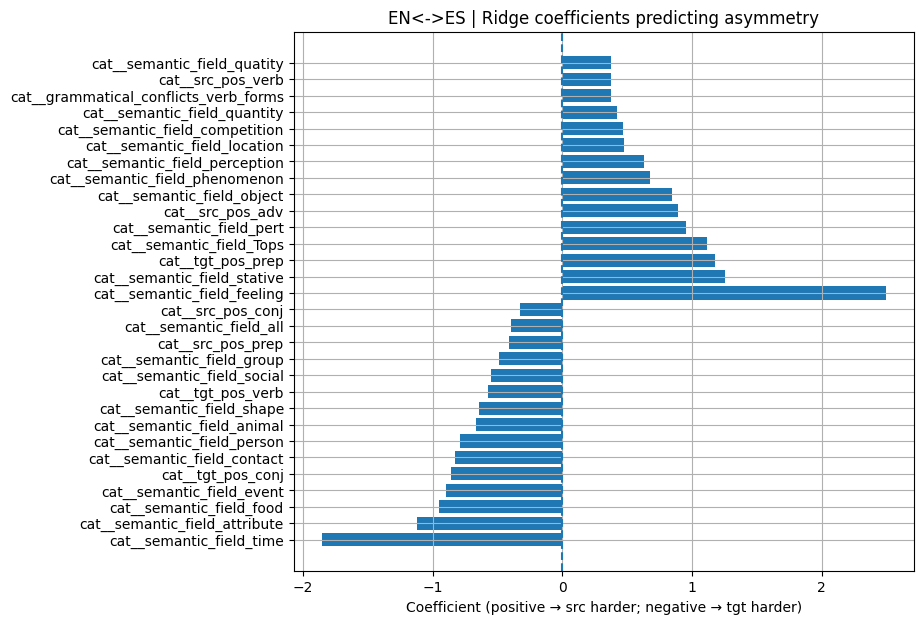

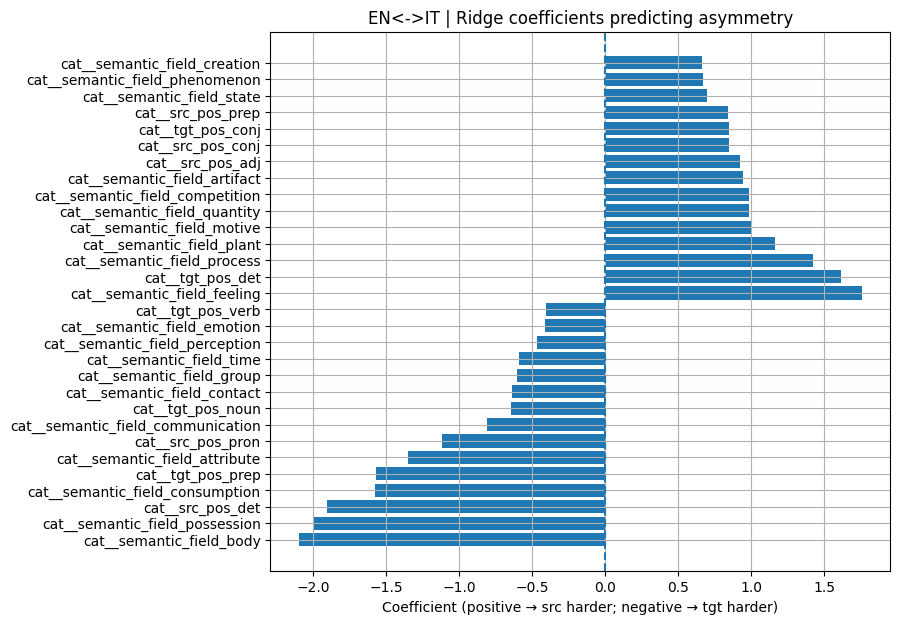

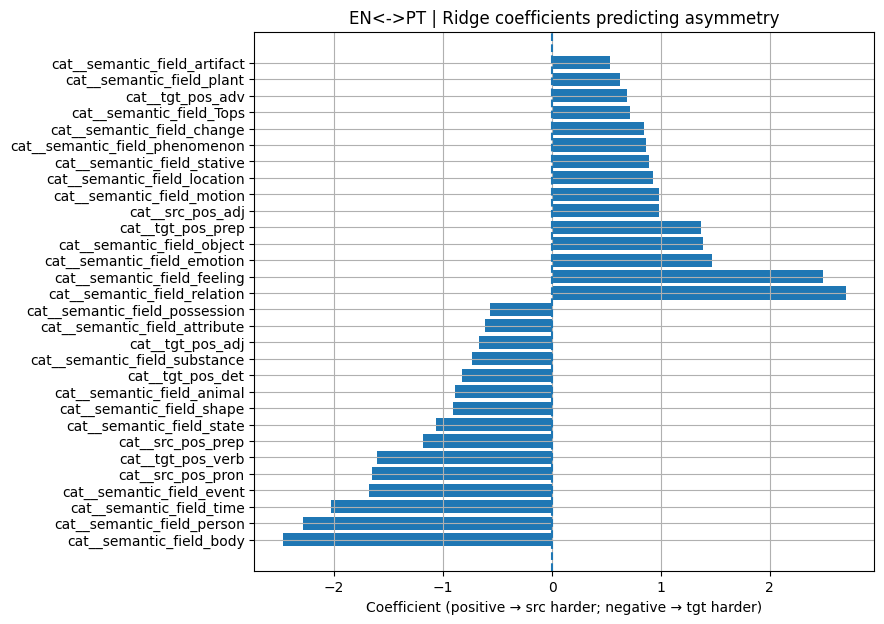

In [9]:
for pair, coef_df in coef_tables.items():
    top_pos = coef_df.sort_values("coef", ascending=False).head(15)
    top_neg = coef_df.sort_values("coef", ascending=True).head(15)
    plot_df = pd.concat([top_neg, top_pos], axis=0)

    plt.figure(figsize=(8, 7))
    plt.barh(plot_df["feature"], plot_df["coef"])
    plt.axvline(0, linestyle="--")
    plt.title(f"{pair} | Ridge coefficients predicting asymmetry")
    plt.xlabel("Coefficient (positive → src harder; negative → tgt harder)")
    plt.grid(True)
    out_plot = DIRS["plots"] / f"coef_asym_{pair.replace('<->','_')}.png"
    plt.savefig(out_plot, bbox_inches="tight")
    plt.show()


## 9 - XGB model trained on asymmetry

In [10]:
xgb_models = {}
xgb_preprocessors = {}
xgb_sanity = []

for pair, df in rq3_data.items():
    train_idx = rq3_splits[pair]["train_idx"]
    test_idx  = rq3_splits[pair]["test_idx"]
    feat_cols = feature_cols_by_pair[pair]

    X_train = df.iloc[train_idx][feat_cols].copy()
    X_test  = df.iloc[test_idx][feat_cols].copy()
    y_train = df.iloc[train_idx]["y_asym"].to_numpy(dtype=float)
    y_test  = df.iloc[test_idx]["y_asym"].to_numpy(dtype=float)

    pre = make_preprocessor_ohe_scale(X_train)
    Xtr = pre.fit_transform(X_train)
    Xte = pre.transform(X_test)

    
    xgb = XGBRegressor(
        n_estimators=800,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    xgb.fit(Xtr, y_train, verbose=False)
    yhat = xgb.predict(Xte)

    m = eval_metrics(y_test, yhat)
    xgb_sanity.append({"pair": pair, **{f"test_{k}": v for k, v in m.items()}})
    print(pair, "XGB sanity metrics:", m)

    xgb_models[pair] = xgb
    xgb_preprocessors[pair] = pre

xgb_sanity_df = pd.DataFrame(xgb_sanity)
xgb_sanity_df.to_csv(DIRS["results"] / "xgb_asym_sanity_metrics.csv", index=False)
display(xgb_sanity_df)


EN<->ES XGB sanity metrics: {'rmse': 1.8271545193440146, 'mae': 1.3164883590122454, 'r2': 0.34776977570454337}
EN<->IT XGB sanity metrics: {'rmse': 2.7412085395618107, 'mae': 1.995949435131797, 'r2': 0.20641538411212668}
EN<->PT XGB sanity metrics: {'rmse': 2.938046335667318, 'mae': 2.191279866594885, 'r2': 0.021399985349496276}


,pair,test_rmse,test_mae,test_r2
0,EN<->ES,1.827155,1.316488,0.347770
1,EN<->IT,2.741209,1.995949,0.206415
2,EN<->PT,2.938046,2.191280,0.021400


## 10 - SHAP summary plots for XGB


[Diag 1] One-hot column sums (EN<->ES)
count     56.000000
mean      18.928571
std       42.123566
min        0.000000
25%        1.000000
50%        4.500000
75%       15.500000
max      196.000000
dtype: float64
[Diag 1] #cat__ cols: 56
[Diag 1] #non-zero cat__ cols: 51

[Diag 2] #features used by XGB (non-zero gain): 69
[Diag 2] #cat__ features used by XGB: 54
[Diag 2] First cat__ used (up to 30):
['cat__src_pos_adj', 'cat__src_pos_adv', 'cat__src_pos_conj', 'cat__src_pos_det', 'cat__src_pos_noun', 'cat__src_pos_prep', 'cat__src_pos_pron', 'cat__src_pos_verb', 'cat__tgt_pos_adj', 'cat__tgt_pos_adv', 'cat__tgt_pos_conj', 'cat__tgt_pos_det', 'cat__tgt_pos_noun', 'cat__tgt_pos_prep', 'cat__tgt_pos_pron', 'cat__tgt_pos_verb', 'cat__grammatical_conflicts_gender_number_forms', 'cat__grammatical_conflicts_no_conflicts', 'cat__grammatical_conflicts_verb_forms', 'cat__semantic_field_Tops', 'cat__semantic_field_act', 'cat__semantic_field_all', 'cat__semantic_field_animal', 'cat__semantic_fie

,feature,mean_abs_shap
58,cat__semantic_field_pert,0.517676
50,cat__semantic_field_feeling,0.462950
70,cat__semantic_field_time,0.422352
39,cat__semantic_field_attribute,0.372172
49,cat__semantic_field_event,0.286709
53,cat__semantic_field_location,0.222901
38,cat__semantic_field_artifact,0.205218
35,cat__semantic_field_act,0.194813
37,cat__semantic_field_animal,0.193414
57,cat__semantic_field_person,0.153381


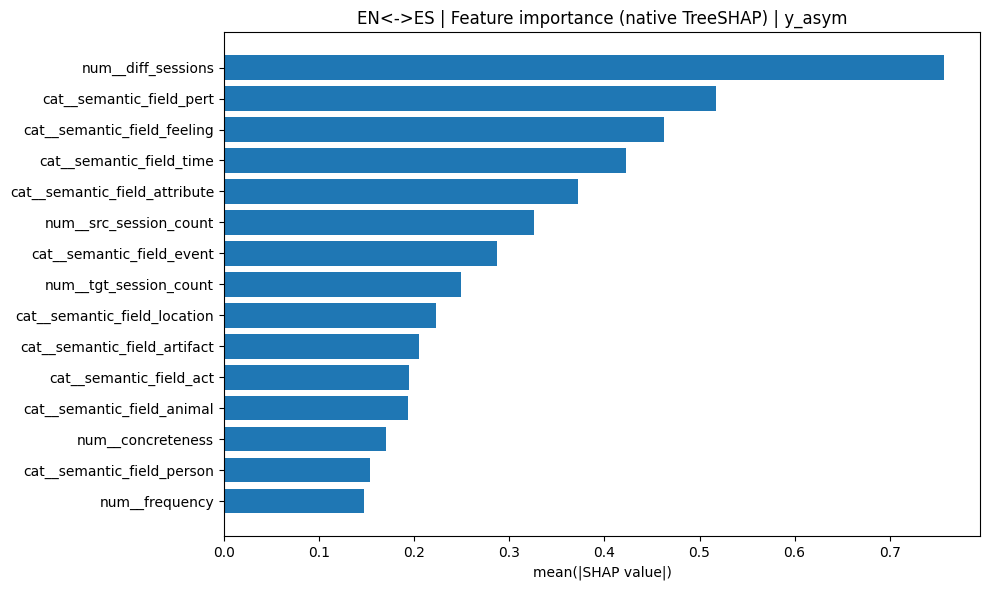

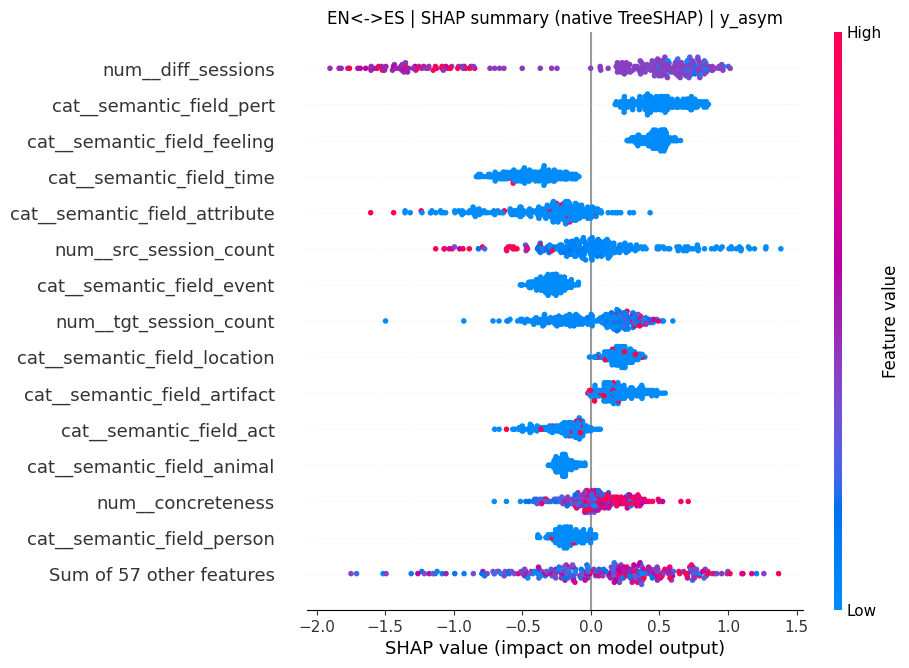

EN<->ES Top 15 SHAP features (native TreeSHAP):


,feature,mean_abs_shap
0,num__diff_sessions,0.757075
1,cat__semantic_field_pert,0.517676
2,cat__semantic_field_feeling,0.462950
3,cat__semantic_field_time,0.422352
4,cat__semantic_field_attribute,0.372172
5,num__src_session_count,0.326008
6,cat__semantic_field_event,0.286709
7,num__tgt_session_count,0.248894
8,cat__semantic_field_location,0.222901
9,cat__semantic_field_artifact,0.205218


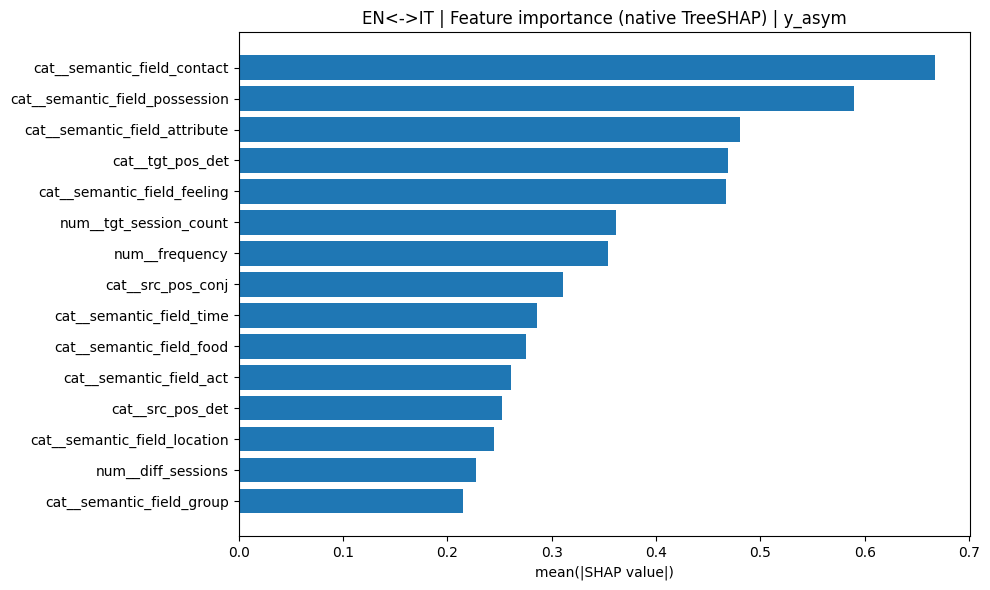

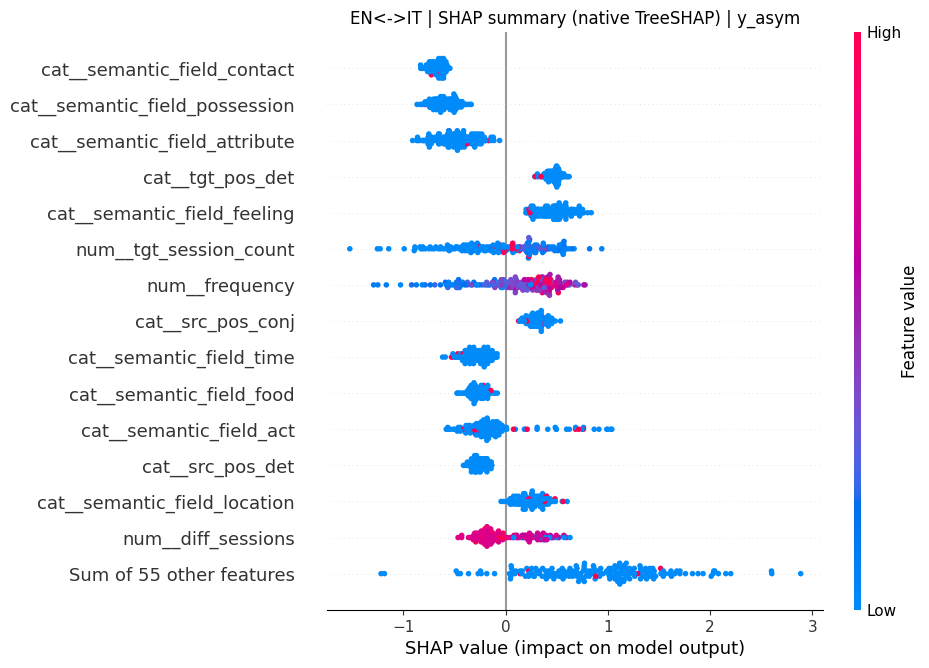

EN<->IT Top 15 SHAP features (native TreeSHAP):


,feature,mean_abs_shap
0,cat__semantic_field_contact,0.667407
1,cat__semantic_field_possession,0.589348
2,cat__semantic_field_attribute,0.480573
3,cat__tgt_pos_det,0.468783
4,cat__semantic_field_feeling,0.466875
5,num__tgt_session_count,0.361430
6,num__frequency,0.354421
7,cat__src_pos_conj,0.310557
8,cat__semantic_field_time,0.285591
9,cat__semantic_field_food,0.275591


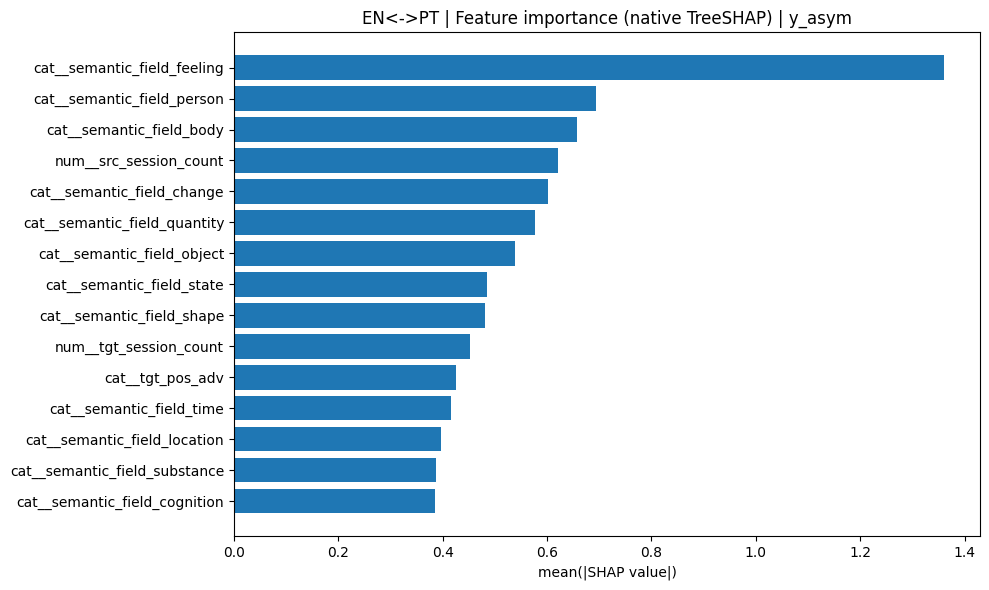

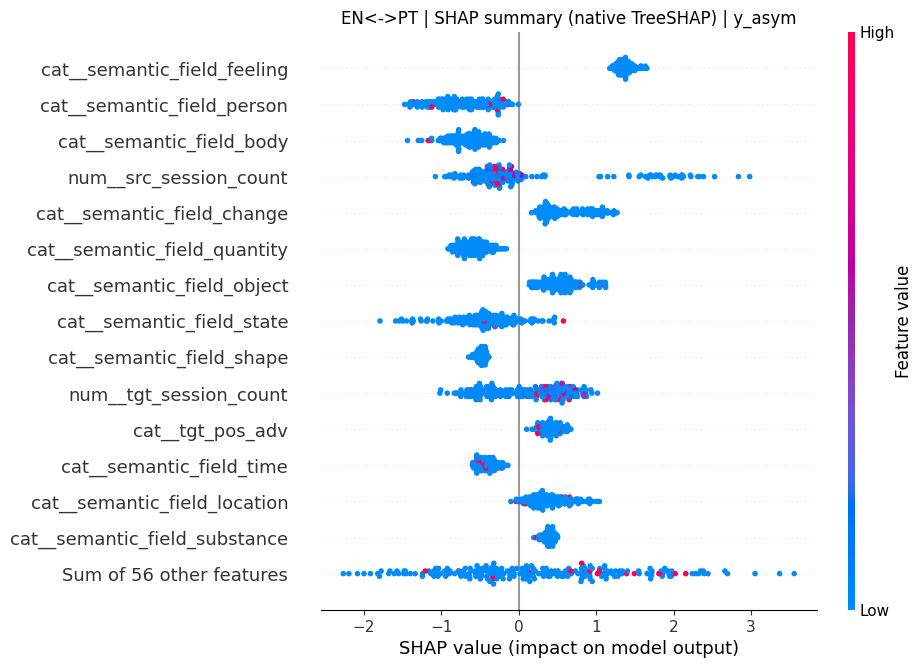

EN<->PT Top 15 SHAP features (native TreeSHAP):


,feature,mean_abs_shap
0,cat__semantic_field_feeling,1.361453
1,cat__semantic_field_person,0.693437
2,cat__semantic_field_body,0.657043
3,num__src_session_count,0.621589
4,cat__semantic_field_change,0.602109
5,cat__semantic_field_quantity,0.576446
6,cat__semantic_field_object,0.538098
7,cat__semantic_field_state,0.484992
8,cat__semantic_field_shape,0.481380
9,num__tgt_session_count,0.452665


In [23]:
import xgboost as xgb

shap_top_tables = {}
shap_values_store = {}

MAX_EXPLAIN_ROWS = 500
TOPN_PLOT = 15

for pair, df in rq3_data.items():
    test_idx  = rq3_splits[pair]["test_idx"]
    feat_cols = feature_cols_by_pair[pair]

    X_test = df.iloc[test_idx][feat_cols].copy()

    pre = xgb_preprocessors[pair]
    model = xgb_models[pair]

    Xte = pre.transform(X_test)
    Xte_dense = safe_to_dense(Xte)

    feature_names = pre.get_feature_names_out().tolist()
    Xte_df = pd.DataFrame(Xte_dense, columns=feature_names)

    if len(Xte_df) > MAX_EXPLAIN_ROWS:
        X_explain = Xte_df.sample(n=MAX_EXPLAIN_ROWS, random_state=RANDOM_STATE)
    else:
        X_explain = Xte_df

    if pair == "EN<->ES":
        cat_cols = [c for c in Xte_df.columns if c.startswith("cat__")]
        print("\n[Diag 1] One-hot column sums (EN<->ES)")
        print(Xte_df[cat_cols].sum().describe())
        print("[Diag 1] #cat__ cols:", len(cat_cols))
        print("[Diag 1] #non-zero cat__ cols:", int((Xte_df[cat_cols].sum() > 0).sum()))

        booster = model.get_booster()
        gain = booster.get_score(importance_type="gain")
        used = sorted({int(k[1:]) for k in gain.keys()})
        used_feature_names = [feature_names[i] for i in used if i < len(feature_names)]
        used_cat = [f for f in used_feature_names if f.startswith("cat__")]
        print("\n[Diag 2] #features used by XGB (non-zero gain):", len(used_feature_names))
        print("[Diag 2] #cat__ features used by XGB:", len(used_cat))
        print("[Diag 2] First cat__ used (up to 30):")
        print(used_cat[:30])

    booster = model.get_booster()
    dmat = xgb.DMatrix(X_explain.values, feature_names=feature_names)
    contrib = booster.predict(dmat, pred_contribs=True)

    shap_native = contrib[:, :-1]
    mean_abs = np.abs(shap_native).mean(axis=0)

    imp_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
    imp_df = imp_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

    shap_top_tables[pair] = imp_df
    shap_values_store[pair] = {
        "values": shap_native,
        "index": X_explain.index.to_numpy(),
        "feature_names": feature_names,
        "X_explain": X_explain,
    }

    if pair == "EN<->ES":
        cat_mask = np.array([f.startswith("cat__") for f in feature_names])
        print("\n[Diag 4] Native TreeSHAP categorical mass (EN<->ES)")
        print("[Diag 4] Sum mean|SHAP| over cat__:", float(mean_abs[cat_mask].sum()))
        print("[Diag 4] Max mean|SHAP| among cat__:", float(mean_abs[cat_mask].max()))
        top_cat = (
            pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
            .assign(is_cat=lambda d: d["feature"].str.startswith("cat__"))
            .query("is_cat")
            .sort_values("mean_abs_shap", ascending=False)
            .head(15)
        )
        print("[Diag 4] Top 15 cat__ by mean(|SHAP|):")
        display(top_cat[["feature", "mean_abs_shap"]])

    out_imp = DIRS["tables"] / f"shap_top_features_{pair.replace('<->','_')}.csv"
    imp_df.to_csv(out_imp, index=False)

    plot_df = imp_df.head(TOPN_PLOT).copy().iloc[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(plot_df["feature"], plot_df["mean_abs_shap"])
    plt.title(f"{pair} | Feature importance (native TreeSHAP) | y_asym")
    plt.xlabel("mean(|SHAP value|)")
    plt.tight_layout()
    out_plot = DIRS["shap"] / f"shap_summary_bar_NATIVE_{pair.replace('<->','_')}.png"
    plt.savefig(out_plot, bbox_inches="tight")
    plt.show()

    native_exp = shap.Explanation(
        values=shap_native,
        base_values=np.zeros(shap_native.shape[0]),
        data=X_explain.values,
        feature_names=feature_names,
    )
    plt.figure()
    shap.plots.beeswarm(native_exp, show=False, max_display=TOPN_PLOT)
    plt.title(f"{pair} | SHAP summary (native TreeSHAP) | y_asym")
    out_plot = DIRS["shap"] / f"shap_beeswarm_NATIVE_{pair.replace('<->','_')}.png"
    plt.savefig(out_plot, bbox_inches="tight")
    plt.show()

    print(pair, "Top 15 SHAP features (native TreeSHAP):")
    display(imp_df.head(15))


## 11 - Directional SHAP analysis (condition on sign of y_asym)

In [25]:
directional_rows = []

for pair, df in rq3_data.items():
    test_idx = rq3_splits[pair]["test_idx"]
    feat_cols = feature_cols_by_pair[pair]

    X_test = df.iloc[test_idx][feat_cols].copy()
    y_test = df.iloc[test_idx]["y_asym"].to_numpy(dtype=float)
    
    store = shap_values_store[pair]
    shap_values = store["values"]
    feature_names = store["feature_names"]
    explain_idx = store["index"]
    
    y_test = y_test[explain_idx]


    #pre = xgb_preprocessors[pair]
    #Xte = safe_to_dense(pre.transform(X_test))
    #feature_names = pre.get_feature_names_out()
    #Xte_df = pd.DataFrame(Xte, columns=feature_names)

    


    mask_pos = y_test > 0
    mask_neg = y_test < 0

    def mean_abs_shap(mask):
        if mask.sum() == 0:
            return np.zeros(shap_values.shape[1])
        return np.abs(shap_values[mask]).mean(axis=0)

    pos_imp = mean_abs_shap(mask_pos)
    neg_imp = mean_abs_shap(mask_neg)

    dir_df = pd.DataFrame({
        "pair": pair,
        "feature": feature_names,
        "mean_abs_shap_src_harder": pos_imp,
        "mean_abs_shap_tgt_harder": neg_imp,
        "delta_src_minus_tgt": pos_imp - neg_imp,
    }).sort_values("delta_src_minus_tgt", ascending=False).reset_index(drop=True)

    out_path = DIRS["tables"] / f"shap_directional_{pair.replace('<->','_')}.csv"
    dir_df.to_csv(out_path, index=False)

    print("\n", pair, "Top 15 features more influential when src is harder (delta>0):")
    display(dir_df.head(15))
    print(pair, "Top 15 features more influential when tgt is harder (delta<0):")
    display(dir_df.tail(15).sort_values("delta_src_minus_tgt", ascending=True))

    
    directional_rows.append({
        "pair": pair,
        "n_test": int(len(y_test)),
        "n_src_harder": int(mask_pos.sum()),
        "n_tgt_harder": int(mask_neg.sum()),
    })

display(pd.DataFrame(directional_rows))



 EN<->ES Top 15 features more influential when src is harder (delta>0):


,pair,feature,mean_abs_shap_src_harder,mean_abs_shap_tgt_harder,delta_src_minus_tgt
0,EN<->ES,num__src_session_count,0.393793,0.299251,0.094541
1,EN<->ES,cat__semantic_field_time,0.488065,0.396413,0.091653
2,EN<->ES,cat__semantic_field_artifact,0.250994,0.187148,0.063846
3,EN<->ES,num__src_lemma_length,0.176040,0.129758,0.046282
4,EN<->ES,cat__semantic_field_event,0.305261,0.279386,0.025875
5,EN<->ES,cat__semantic_field_communication,0.137251,0.117180,0.020072
6,EN<->ES,num__diff_lexeme_count,0.058477,0.039932,0.018546
7,EN<->ES,cat__semantic_field_possession,0.117076,0.098713,0.018364
8,EN<->ES,cat__src_pos_adj,0.071237,0.055577,0.015660
9,EN<->ES,cat__semantic_field_cognition,0.065720,0.050954,0.014766


EN<->ES Top 15 features more influential when tgt is harder (delta<0):


,pair,feature,mean_abs_shap_src_harder,mean_abs_shap_tgt_harder,delta_src_minus_tgt
70,EN<->ES,cat__semantic_field_attribute,0.277469,0.409555,-0.132087
69,EN<->ES,num__concreteness,0.146566,0.179978,-0.033413
68,EN<->ES,cat__src_pos_noun,0.060005,0.086759,-0.026753
67,EN<->ES,num__diff_sessions,0.740662,0.763555,-0.022892
66,EN<->ES,cat__semantic_field_state,0.119751,0.135593,-0.015842
65,EN<->ES,cat__semantic_field_object,0.060689,0.075350,-0.014661
64,EN<->ES,cat__semantic_field_feeling,0.453051,0.466857,-0.013806
63,EN<->ES,cat__semantic_field_person,0.144248,0.156986,-0.012738
62,EN<->ES,num__frequency,0.138645,0.151081,-0.012436
61,EN<->ES,cat__semantic_field_location,0.214390,0.226260,-0.011870



 EN<->IT Top 15 features more influential when src is harder (delta>0):


,pair,feature,mean_abs_shap_src_harder,mean_abs_shap_tgt_harder,delta_src_minus_tgt
0,EN<->IT,cat__semantic_field_feeling,0.494364,0.412326,0.082038
1,EN<->IT,cat__semantic_field_time,0.308945,0.239248,0.069698
2,EN<->IT,cat__semantic_field_food,0.295732,0.235623,0.060108
3,EN<->IT,cat__semantic_field_person,0.213720,0.170377,0.043343
4,EN<->IT,num__diff_len,0.117035,0.078239,0.038797
5,EN<->IT,cat__semantic_field_contact,0.679148,0.644109,0.035039
6,EN<->IT,cat__tgt_pos_prep,0.205345,0.177898,0.027448
7,EN<->IT,num__diff_lexeme_count,0.068061,0.047947,0.020114
8,EN<->IT,cat__semantic_field_possession,0.595823,0.576500,0.019323
9,EN<->IT,cat__semantic_field_state,0.196151,0.183299,0.012852


EN<->IT Top 15 features more influential when tgt is harder (delta<0):


,pair,feature,mean_abs_shap_src_harder,mean_abs_shap_tgt_harder,delta_src_minus_tgt
68,EN<->IT,num__src_session_count,0.147816,0.280728,-0.132912
67,EN<->IT,num__concreteness,0.175029,0.291353,-0.116324
66,EN<->IT,cat__semantic_field_act,0.231116,0.319901,-0.088785
65,EN<->IT,num__tgt_session_count,0.333153,0.417542,-0.084389
64,EN<->IT,cat__tgt_pos_adj,0.052782,0.131942,-0.079161
63,EN<->IT,num__frequency,0.330515,0.401858,-0.071343
62,EN<->IT,num__tgt_lemma_length,0.097833,0.165618,-0.067785
61,EN<->IT,num__src_lemma_length,0.082831,0.130650,-0.047819
60,EN<->IT,cat__semantic_field_event,0.054545,0.097150,-0.042604
59,EN<->IT,cat__semantic_field_attribute,0.467116,0.507276,-0.040160



 EN<->PT Top 15 features more influential when src is harder (delta>0):


,pair,feature,mean_abs_shap_src_harder,mean_abs_shap_tgt_harder,delta_src_minus_tgt
0,EN<->PT,num__src_session_count,0.755775,0.472493,0.283283
1,EN<->PT,cat__semantic_field_change,0.665451,0.531729,0.133721
2,EN<->PT,cat__semantic_field_state,0.545425,0.417843,0.127582
3,EN<->PT,cat__semantic_field_motion,0.388254,0.338075,0.050179
4,EN<->PT,num__concreteness,0.406742,0.361046,0.045697
5,EN<->PT,cat__semantic_field_body,0.677681,0.634111,0.043570
6,EN<->PT,cat__semantic_field_quantity,0.596982,0.553628,0.043354
7,EN<->PT,cat__tgt_pos_det,0.306753,0.276168,0.030586
8,EN<->PT,num__diff_len,0.152858,0.129979,0.022879
9,EN<->PT,num__meaning_conflicts,0.133609,0.112169,0.021441


EN<->PT Top 15 features more influential when tgt is harder (delta<0):


,pair,feature,mean_abs_shap_src_harder,mean_abs_shap_tgt_harder,delta_src_minus_tgt
69,EN<->PT,cat__semantic_field_emotion,0.139321,0.184363,-0.045042
68,EN<->PT,cat__semantic_field_object,0.521654,0.556370,-0.034717
67,EN<->PT,cat__semantic_field_location,0.382588,0.412125,-0.029537
66,EN<->PT,cat__tgt_pos_adv,0.413748,0.437473,-0.023725
65,EN<->PT,num__tgt_lexeme_count,0.104457,0.121945,-0.017488
64,EN<->PT,cat__semantic_field_phenomenon,0.195241,0.212281,-0.017040
63,EN<->PT,cat__semantic_field_social,0.090065,0.106648,-0.016583
62,EN<->PT,num__src_lemma_length,0.176677,0.192994,-0.016318
61,EN<->PT,num__diff_lexeme_count,0.123105,0.138517,-0.015412
60,EN<->PT,cat__semantic_field_Tops,0.124978,0.139044,-0.014065


,pair,n_test,n_src_harder,n_tgt_harder
0,EN<->ES,265,75,190
1,EN<->IT,191,127,64
2,EN<->PT,228,120,108


## 12 - Subgroup analysis: POS + semantic_field + frequency bins

In [28]:
def add_freq_bins(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if "frequency" in df.columns:
        base = pd.to_numeric(df["frequency"], errors="coerce")
        base_name = "frequency"
    elif "src_session_count" in df.columns:
        base = pd.to_numeric(df["src_session_count"], errors="coerce")
        base_name = "src_session_count"
    else:
        df["freq_bin"] = "NA"
        return df, None

    df["freq_bin"] = pd.qcut(
        base.rank(method="first"),
        q=4,
        labels=["Q1","Q2","Q3","Q4"]
    )
    return df, base_name


subgroup_outputs = []

for pair, df in rq3_data.items():
    test_idx = rq3_splits[pair]["test_idx"]
    df_test = df.iloc[test_idx].copy()

    df_test, freq_used = add_freq_bins(df_test)
    print(pair, "freq bin based on:", freq_used)

    store = shap_values_store[pair]
    shap_vals = store["values"]
    feature_names = store["feature_names"]
    explain_idx = store["index"]

    df_explain = df_test.iloc[explain_idx].copy()

    mean_abs_global = np.abs(shap_vals).mean(axis=0)
    top_features = (
        pd.Series(mean_abs_global, index=feature_names)
        .sort_values(ascending=False)
        .head(15)
        .index
        .tolist()
    )
    top_idx = [list(feature_names).index(f) for f in top_features]

    def subgroup_table(group_col: str):
        rows = []
        for g, sub in df_explain.groupby(group_col):
            row_pos = df_explain.index.get_indexer(sub.index)
            row_pos = row_pos[row_pos >= 0]
            if len(row_pos) == 0:
                continue

            sv = shap_vals[row_pos][:, top_idx]

            rows.append({
                "pair": pair,
                "group_col": group_col,
                "group": g,
                "n": int(len(row_pos)),
                "mean_y_asym": float(sub["y_asym"].mean()),
                "pct_src_harder": float((sub["y_asym"] > 0).mean()),
                **{f"mean_abs_shap__{top_features[i]}": float(np.abs(sv[:, i]).mean()) for i in range(len(top_features))}
            })

        return pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)

    if "src_pos" in df_explain.columns:
        pos_tbl = subgroup_table("src_pos")
        pos_tbl.to_csv(DIRS["tables"] / f"subgroup_pos_{pair.replace('<->','_')}.csv", index=False)
        display(pos_tbl.head(10))

    if "semantic_field" in df_explain.columns:
        sem_tbl = subgroup_table("semantic_field")
        sem_tbl.to_csv(DIRS["tables"] / f"subgroup_semfield_{pair.replace('<->','_')}.csv", index=False)
        display(sem_tbl.head(10))

    if "freq_bin" in df_explain.columns:
        freq_tbl = subgroup_table("freq_bin")
        freq_tbl.to_csv(DIRS["tables"] / f"subgroup_freqbin_{pair.replace('<->','_')}.csv", index=False)
        display(freq_tbl)

    subgroup_outputs.append({"pair": pair, "freq_bin_based_on": freq_used})

display(pd.DataFrame(subgroup_outputs))


EN<->ES freq bin based on: frequency


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__num__diff_sessions,mean_abs_shap__cat__semantic_field_pert,mean_abs_shap__cat__semantic_field_feeling,mean_abs_shap__cat__semantic_field_time,...,mean_abs_shap__num__src_session_count,mean_abs_shap__cat__semantic_field_event,mean_abs_shap__num__tgt_session_count,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__cat__semantic_field_artifact,mean_abs_shap__cat__semantic_field_act,mean_abs_shap__cat__semantic_field_animal,mean_abs_shap__num__concreteness,mean_abs_shap__cat__semantic_field_person,mean_abs_shap__num__frequency
0,EN<->ES,src_pos,noun,194,-1.119362,0.273196,0.686336,0.519412,0.450708,0.434151,...,0.363032,0.278122,0.257906,0.229252,0.226199,0.185940,0.186047,0.162659,0.162834,0.151563
1,EN<->ES,src_pos,adj,28,-0.856057,0.178571,1.093136,0.463084,0.474376,0.361644,...,0.111107,0.306328,0.216817,0.224515,0.156893,0.204122,0.209418,0.195865,0.133220,0.117046
2,EN<->ES,src_pos,verb,23,-0.143816,0.434783,0.763832,0.520402,0.485959,0.395134,...,0.207264,0.324605,0.201560,0.239214,0.102250,0.144886,0.184422,0.149784,0.189742,0.125460
3,EN<->ES,src_pos,adv,10,-0.397570,0.400000,0.814545,0.579293,0.551662,0.460598,...,0.319623,0.293023,0.258294,0.134105,0.175158,0.306233,0.240287,0.255385,0.046150,0.124495
4,EN<->ES,src_pos,prep,6,-0.568400,0.333333,0.942975,0.605641,0.522512,0.401561,...,0.611399,0.286380,0.312276,0.127076,0.205702,0.361861,0.262282,0.224100,0.035752,0.198519
5,EN<->ES,src_pos,det,2,-2.891946,0.000000,1.490313,0.433498,0.551635,0.270341,...,0.208191,0.309869,0.126692,0.138466,0.162321,0.400612,0.280517,0.268692,0.042514,0.378926
6,EN<->ES,src_pos,conj,1,-3.061781,0.000000,1.548892,0.478597,0.549786,0.347837,...,0.472756,0.283417,0.280619,0.184767,0.179146,0.393856,0.298446,0.263409,0.003976,0.261106
7,EN<->ES,src_pos,pron,1,1.153508,1.000000,0.967076,0.710327,0.479920,0.580090,...,0.332186,0.427460,0.225796,0.240292,0.265672,0.076903,0.220196,0.004003,0.196804,0.082720


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__num__diff_sessions,mean_abs_shap__cat__semantic_field_pert,mean_abs_shap__cat__semantic_field_feeling,mean_abs_shap__cat__semantic_field_time,...,mean_abs_shap__num__src_session_count,mean_abs_shap__cat__semantic_field_event,mean_abs_shap__num__tgt_session_count,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__cat__semantic_field_artifact,mean_abs_shap__cat__semantic_field_act,mean_abs_shap__cat__semantic_field_animal,mean_abs_shap__num__concreteness,mean_abs_shap__cat__semantic_field_person,mean_abs_shap__num__frequency
0,EN<->ES,semantic_field,all,41,-0.864087,0.219512,1.048410,0.497082,0.500115,0.386551,...,0.213320,0.303813,0.243933,0.192265,0.168440,0.253866,0.225583,0.218821,0.090832,0.145137
1,EN<->ES,semantic_field,artifact,30,-1.684462,0.233333,0.641973,0.631870,0.489092,0.466345,...,0.301721,0.270295,0.279066,0.193836,0.145446,0.243165,0.166035,0.141083,0.137057,0.172742
2,EN<->ES,semantic_field,act,26,-1.144341,0.192308,0.796154,0.426151,0.424932,0.374878,...,0.498751,0.261709,0.208092,0.223908,0.274597,0.174041,0.197396,0.137664,0.172761,0.158852
3,EN<->ES,semantic_field,communication,23,-0.592705,0.260870,0.660380,0.460303,0.409899,0.394369,...,0.415697,0.264027,0.342329,0.242534,0.224096,0.134221,0.165769,0.161774,0.207007,0.139006
4,EN<->ES,semantic_field,cognition,17,0.181321,0.411765,0.718972,0.489824,0.428920,0.488460,...,0.588526,0.270114,0.199985,0.243736,0.282222,0.189893,0.175704,0.148812,0.123859,0.122170
5,EN<->ES,semantic_field,person,15,-3.041865,0.200000,0.791644,0.536211,0.473285,0.390537,...,0.386321,0.260941,0.230914,0.235431,0.194411,0.181030,0.193748,0.216790,0.183171,0.140512
6,EN<->ES,semantic_field,attribute,13,-1.792949,0.384615,0.796995,0.405981,0.445899,0.321444,...,0.209913,0.333941,0.170060,0.257127,0.273055,0.107535,0.192605,0.188988,0.154510,0.176511
7,EN<->ES,semantic_field,location,11,1.080307,0.636364,0.559202,0.630799,0.457978,0.429549,...,0.279297,0.276552,0.288223,0.240220,0.223827,0.276594,0.218065,0.135069,0.184225,0.169110
8,EN<->ES,semantic_field,group,10,-1.003631,0.200000,0.593318,0.548263,0.452645,0.410052,...,0.218354,0.270125,0.270241,0.211933,0.239224,0.215640,0.211276,0.177650,0.180433,0.117936
9,EN<->ES,semantic_field,time,10,-1.525378,0.100000,0.599642,0.538309,0.488737,0.556858,...,0.236578,0.337525,0.233507,0.231647,0.192849,0.077048,0.189048,0.164128,0.194862,0.101945


C:\Users\paolo\AppData\Local\Temp\ipykernel_15512\271629845.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_explain.groupby(group_col):


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__num__diff_sessions,mean_abs_shap__cat__semantic_field_pert,mean_abs_shap__cat__semantic_field_feeling,mean_abs_shap__cat__semantic_field_time,...,mean_abs_shap__num__src_session_count,mean_abs_shap__cat__semantic_field_event,mean_abs_shap__num__tgt_session_count,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__cat__semantic_field_artifact,mean_abs_shap__cat__semantic_field_act,mean_abs_shap__cat__semantic_field_animal,mean_abs_shap__num__concreteness,mean_abs_shap__cat__semantic_field_person,mean_abs_shap__num__frequency
0,EN<->ES,freq_bin,Q1,67,-0.817148,0.328358,0.726996,0.482970,0.455311,0.492186,...,0.380492,0.293863,0.264000,0.238119,0.208393,0.162955,0.127778,0.163504,0.150654,0.161535
1,EN<->ES,freq_bin,Q2,66,-1.117513,0.257576,0.812398,0.482249,0.444612,0.440613,...,0.359111,0.289370,0.256597,0.265159,0.207068,0.125493,0.200898,0.179287,0.159785,0.147788
2,EN<->ES,freq_bin,Q3,66,-0.839949,0.287879,0.669934,0.532436,0.453616,0.399761,...,0.248724,0.296269,0.253111,0.237579,0.200350,0.200858,0.208746,0.153555,0.166861,0.134269
3,EN<->ES,freq_bin,Q4,66,-1.145008,0.257576,0.819429,0.573576,0.498376,0.355791,...,0.314881,0.267226,0.221640,0.150516,0.205011,0.290430,0.237230,0.185848,0.136264,0.146443


EN<->IT freq bin based on: frequency


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__cat__semantic_field_contact,mean_abs_shap__cat__semantic_field_possession,mean_abs_shap__cat__semantic_field_attribute,mean_abs_shap__cat__tgt_pos_det,...,mean_abs_shap__num__tgt_session_count,mean_abs_shap__num__frequency,mean_abs_shap__cat__src_pos_conj,mean_abs_shap__cat__semantic_field_time,mean_abs_shap__cat__semantic_field_food,mean_abs_shap__cat__semantic_field_act,mean_abs_shap__cat__src_pos_det,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__num__diff_sessions,mean_abs_shap__cat__semantic_field_group
0,EN<->IT,src_pos,noun,124,0.663947,0.620968,0.671600,0.595654,0.501756,0.469910,...,0.405780,0.344453,0.323967,0.287911,0.270049,0.282613,0.262664,0.257513,0.230354,0.240981
1,EN<->IT,src_pos,adj,21,1.202474,0.761905,0.643344,0.587507,0.577707,0.492743,...,0.322613,0.502655,0.323962,0.302618,0.281732,0.308594,0.216952,0.296934,0.212183,0.219403
2,EN<->IT,src_pos,verb,20,0.068662,0.650000,0.693953,0.601255,0.422381,0.456278,...,0.268970,0.265275,0.268328,0.277891,0.283268,0.191592,0.221705,0.207420,0.209946,0.155387
3,EN<->IT,src_pos,adv,12,1.629642,0.916667,0.646431,0.560104,0.325614,0.510868,...,0.309130,0.352880,0.281443,0.292116,0.307622,0.215079,0.290028,0.208327,0.209372,0.137753
4,EN<->IT,src_pos,conj,5,2.952555,1.000000,0.683958,0.550344,0.296728,0.424296,...,0.150774,0.276245,0.265014,0.240281,0.294063,0.111599,0.243209,0.105649,0.166170,0.127124
5,EN<->IT,src_pos,prep,4,0.639844,0.750000,0.635865,0.476624,0.252183,0.339521,...,0.119709,0.373973,0.214311,0.214804,0.272033,0.118163,0.210019,0.084921,0.323161,0.127338
6,EN<->IT,src_pos,det,3,0.738279,0.666667,0.608270,0.591423,0.471004,0.496961,...,0.415648,0.484876,0.349703,0.300020,0.256986,0.146400,0.254520,0.244767,0.221955,0.172904
7,EN<->IT,src_pos,pron,2,-3.292975,0.000000,0.630980,0.593916,0.589738,0.347324,...,0.186447,0.277323,0.182936,0.234031,0.274567,0.209187,0.190840,0.139199,0.424509,0.044581


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__cat__semantic_field_contact,mean_abs_shap__cat__semantic_field_possession,mean_abs_shap__cat__semantic_field_attribute,mean_abs_shap__cat__tgt_pos_det,...,mean_abs_shap__num__tgt_session_count,mean_abs_shap__num__frequency,mean_abs_shap__cat__src_pos_conj,mean_abs_shap__cat__semantic_field_time,mean_abs_shap__cat__semantic_field_food,mean_abs_shap__cat__semantic_field_act,mean_abs_shap__cat__src_pos_det,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__num__diff_sessions,mean_abs_shap__cat__semantic_field_group
0,EN<->IT,semantic_field,all,41,1.247984,0.780488,0.646661,0.571949,0.467699,0.477140,...,0.289791,0.425081,0.294057,0.286838,0.290781,0.244573,0.234882,0.231376,0.225734,0.165386
1,EN<->IT,semantic_field,artifact,20,1.813668,0.700000,0.722602,0.632779,0.597480,0.424854,...,0.489869,0.299565,0.335398,0.290680,0.272368,0.173549,0.240613,0.199401,0.337641,0.202267
2,EN<->IT,semantic_field,cognition,16,0.668243,0.625000,0.646434,0.529360,0.417947,0.481234,...,0.432638,0.393623,0.258891,0.276071,0.282619,0.303411,0.275639,0.261977,0.189158,0.211204
3,EN<->IT,semantic_field,communication,15,0.520922,0.666667,0.673838,0.585573,0.459411,0.462930,...,0.366553,0.332114,0.308880,0.276154,0.278584,0.238919,0.272159,0.212875,0.241184,0.190827
4,EN<->IT,semantic_field,act,12,-1.738272,0.250000,0.625870,0.556578,0.484324,0.502517,...,0.505158,0.528280,0.314246,0.267729,0.235350,0.361843,0.267642,0.288143,0.169993,0.253596
5,EN<->IT,semantic_field,quantity,10,0.991901,0.700000,0.649050,0.667634,0.515196,0.472311,...,0.341974,0.272290,0.373025,0.303765,0.318873,0.193034,0.264586,0.241798,0.207032,0.266042
6,EN<->IT,semantic_field,time,8,0.644507,0.875000,0.737623,0.608578,0.578513,0.470060,...,0.389072,0.175204,0.354582,0.446654,0.289893,0.231314,0.203023,0.210200,0.195659,0.229268
7,EN<->IT,semantic_field,location,8,0.708787,0.625000,0.647969,0.646013,0.474443,0.484931,...,0.403201,0.281387,0.328304,0.303276,0.269761,0.331272,0.281170,0.337617,0.246676,0.344183
8,EN<->IT,semantic_field,phenomenon,7,0.442131,0.571429,0.680960,0.537932,0.470881,0.473674,...,0.414016,0.366651,0.270881,0.268345,0.300918,0.191624,0.288650,0.359098,0.200891,0.294371
9,EN<->IT,semantic_field,state,6,0.640964,0.666667,0.613977,0.502459,0.413844,0.485056,...,0.211942,0.195247,0.261142,0.253241,0.265442,0.287637,0.265053,0.317213,0.196361,0.118109


C:\Users\paolo\AppData\Local\Temp\ipykernel_15512\271629845.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_explain.groupby(group_col):


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__cat__semantic_field_contact,mean_abs_shap__cat__semantic_field_possession,mean_abs_shap__cat__semantic_field_attribute,mean_abs_shap__cat__tgt_pos_det,...,mean_abs_shap__num__tgt_session_count,mean_abs_shap__num__frequency,mean_abs_shap__cat__src_pos_conj,mean_abs_shap__cat__semantic_field_time,mean_abs_shap__cat__semantic_field_food,mean_abs_shap__cat__semantic_field_act,mean_abs_shap__cat__src_pos_det,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__num__diff_sessions,mean_abs_shap__cat__semantic_field_group
0,EN<->IT,freq_bin,Q1,48,0.514817,0.583333,0.653860,0.581770,0.496327,0.446102,...,0.482401,0.479841,0.305214,0.191395,0.255627,0.218159,0.248663,0.208838,0.244996,0.197940
1,EN<->IT,freq_bin,Q2,48,0.561091,0.604167,0.668648,0.610605,0.555107,0.460159,...,0.354302,0.215401,0.332205,0.283314,0.300192,0.252344,0.255486,0.250159,0.256142,0.227276
2,EN<->IT,freq_bin,Q4,48,1.289560,0.791667,0.681620,0.589178,0.354418,0.485469,...,0.277492,0.416517,0.283151,0.331043,0.278832,0.216838,0.247446,0.212703,0.216278,0.179024
3,EN<->IT,freq_bin,Q3,47,0.594021,0.680851,0.665461,0.575552,0.517203,0.483712,...,0.330888,0.304893,0.321893,0.337699,0.267542,0.358151,0.258843,0.307544,0.190076,0.255302


EN<->PT freq bin based on: frequency


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__cat__semantic_field_feeling,mean_abs_shap__cat__semantic_field_person,mean_abs_shap__cat__semantic_field_body,mean_abs_shap__num__src_session_count,...,mean_abs_shap__cat__semantic_field_quantity,mean_abs_shap__cat__semantic_field_object,mean_abs_shap__cat__semantic_field_state,mean_abs_shap__cat__semantic_field_shape,mean_abs_shap__num__tgt_session_count,mean_abs_shap__cat__tgt_pos_adv,mean_abs_shap__cat__semantic_field_time,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__cat__semantic_field_substance,mean_abs_shap__cat__semantic_field_cognition
0,EN<->PT,src_pos,noun,154,0.546419,0.564935,1.375861,0.737103,0.721897,0.716668,...,0.583325,0.504391,0.560509,0.491974,0.482961,0.440803,0.402648,0.403872,0.394465,0.434383
1,EN<->PT,src_pos,verb,33,-0.400990,0.515152,1.315873,0.586916,0.569618,0.476808,...,0.648102,0.565804,0.359204,0.460929,0.416295,0.401664,0.416311,0.444808,0.402829,0.332095
2,EN<->PT,src_pos,adv,15,0.138921,0.533333,1.308788,0.754344,0.536860,0.394835,...,0.434613,0.630350,0.304529,0.461290,0.409179,0.348129,0.464680,0.360781,0.360997,0.265662
3,EN<->PT,src_pos,adj,14,-0.376664,0.285714,1.399781,0.555947,0.515146,0.372796,...,0.561051,0.524240,0.288668,0.467596,0.299918,0.446969,0.493176,0.389951,0.359077,0.288027
4,EN<->PT,src_pos,det,5,-2.510071,0.000000,1.320111,0.330217,0.283231,0.305634,...,0.575966,0.933294,0.221577,0.431049,0.427909,0.340741,0.377076,0.166312,0.312213,0.146261
5,EN<->PT,src_pos,prep,4,0.399200,0.500000,1.342134,0.774366,0.375580,0.452583,...,0.282060,0.672333,0.442922,0.452426,0.345538,0.394242,0.455213,0.200942,0.332369,0.199427
6,EN<->PT,src_pos,pron,2,4.605678,1.000000,1.310114,0.604911,0.640450,0.516394,...,0.723363,0.764850,0.350925,0.460427,0.336568,0.376304,0.449322,0.421279,0.342985,0.160398
7,EN<->PT,src_pos,conj,1,-0.172705,0.000000,1.286753,0.164898,0.371900,0.107731,...,0.381625,0.658564,0.215343,0.428402,0.562385,0.245377,0.505108,0.196081,0.274882,0.264515


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__cat__semantic_field_feeling,mean_abs_shap__cat__semantic_field_person,mean_abs_shap__cat__semantic_field_body,mean_abs_shap__num__src_session_count,...,mean_abs_shap__cat__semantic_field_quantity,mean_abs_shap__cat__semantic_field_object,mean_abs_shap__cat__semantic_field_state,mean_abs_shap__cat__semantic_field_shape,mean_abs_shap__num__tgt_session_count,mean_abs_shap__cat__tgt_pos_adv,mean_abs_shap__cat__semantic_field_time,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__cat__semantic_field_substance,mean_abs_shap__cat__semantic_field_cognition
0,EN<->PT,semantic_field,all,32,-0.399729,0.343750,1.335546,0.586511,0.491635,0.375423,...,0.500464,0.649890,0.291149,0.458212,0.383879,0.378778,0.458495,0.328452,0.347983,0.253835
1,EN<->PT,semantic_field,artifact,28,0.522141,0.642857,1.343775,0.838983,0.857341,0.373200,...,0.528590,0.527852,0.561588,0.475627,0.488946,0.508661,0.353981,0.417942,0.378247,0.446719
2,EN<->PT,semantic_field,cognition,18,0.831972,0.611111,1.421847,0.613150,0.659869,1.058045,...,0.696932,0.393881,0.427456,0.506940,0.417228,0.382906,0.427045,0.378621,0.426616,0.510745
3,EN<->PT,semantic_field,communication,18,0.512875,0.555556,1.402217,0.716396,0.716397,0.764830,...,0.645710,0.470749,0.619548,0.504179,0.476431,0.459956,0.373598,0.465828,0.411925,0.510984
4,EN<->PT,semantic_field,act,13,1.017457,0.615385,1.381234,0.712881,0.631906,1.256512,...,0.575134,0.475183,0.443763,0.511780,0.366553,0.383090,0.427959,0.379210,0.404163,0.399112
5,EN<->PT,semantic_field,time,11,-0.356364,0.272727,1.347728,0.769031,0.534269,0.232144,...,0.476904,0.513260,0.547238,0.462273,0.459855,0.476426,0.421428,0.440900,0.384842,0.314617
6,EN<->PT,semantic_field,person,11,0.262746,0.454545,1.398163,0.514417,0.563807,0.687874,...,0.489432,0.475017,0.474065,0.472531,0.466346,0.433928,0.356019,0.397028,0.367833,0.412050
7,EN<->PT,semantic_field,attribute,10,-1.225888,0.300000,1.397405,0.799745,0.700157,0.999454,...,0.678778,0.506900,0.709403,0.511015,0.450158,0.425493,0.371779,0.423337,0.431398,0.292435
8,EN<->PT,semantic_field,group,8,1.022618,0.625000,1.385607,0.952183,0.686160,0.545871,...,0.619001,0.468781,0.598420,0.500658,0.488164,0.443059,0.409850,0.516009,0.435378,0.274926
9,EN<->PT,semantic_field,location,7,0.829594,0.428571,1.356492,0.990373,0.711837,0.590718,...,0.645334,0.561581,0.554225,0.511923,0.615174,0.356168,0.484067,0.239023,0.396461,0.457018


C:\Users\paolo\AppData\Local\Temp\ipykernel_15512\271629845.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_explain.groupby(group_col):


,pair,group_col,group,n,mean_y_asym,pct_src_harder,mean_abs_shap__cat__semantic_field_feeling,mean_abs_shap__cat__semantic_field_person,mean_abs_shap__cat__semantic_field_body,mean_abs_shap__num__src_session_count,...,mean_abs_shap__cat__semantic_field_quantity,mean_abs_shap__cat__semantic_field_object,mean_abs_shap__cat__semantic_field_state,mean_abs_shap__cat__semantic_field_shape,mean_abs_shap__num__tgt_session_count,mean_abs_shap__cat__tgt_pos_adv,mean_abs_shap__cat__semantic_field_time,mean_abs_shap__cat__semantic_field_location,mean_abs_shap__cat__semantic_field_substance,mean_abs_shap__cat__semantic_field_cognition
0,EN<->PT,freq_bin,Q1,57,0.210602,0.508772,1.385548,0.611796,0.761706,0.684428,...,0.532681,0.454591,0.415492,0.496803,0.512317,0.461495,0.400196,0.523650,0.375207,0.475131
1,EN<->PT,freq_bin,Q2,57,0.553112,0.543860,1.386414,0.788633,0.724487,0.766679,...,0.664170,0.503625,0.522135,0.488705,0.470403,0.468931,0.410279,0.524606,0.407494,0.476871
2,EN<->PT,freq_bin,Q3,57,0.706503,0.578947,1.369761,0.750691,0.674389,0.604778,...,0.597404,0.534742,0.585402,0.480284,0.461245,0.466341,0.408479,0.336149,0.399087,0.342007
3,EN<->PT,freq_bin,Q4,57,-0.315631,0.473684,1.304089,0.622629,0.467590,0.430471,...,0.511530,0.659435,0.416938,0.459728,0.366695,0.303176,0.442989,0.201910,0.367939,0.249601


,pair,freq_bin_based_on
0,EN<->ES,frequency
1,EN<->IT,frequency
2,EN<->PT,frequency


## 13 - Automatically select strong asymmetry examples + local SHAP drivers

In [29]:
def get_lex_cols(df: pd.DataFrame):
    src_word = "src_lemma" if "src_lemma" in df.columns else None
    tgt_word = "tgt_lemma" if "tgt_lemma" in df.columns else None
    return src_word, tgt_word

TOPK_LOCAL = 3

for pair, df in rq3_data.items():
    src_word_col, tgt_word_col = get_lex_cols(df)
    id_col = "row_id" if "row_id" in df.columns else None

    
    test_idx  = rq3_splits[pair]["test_idx"]
    df_test = df.iloc[test_idx].copy().reset_index(drop=False)  

    
    pre = xgb_preprocessors[pair]
    feature_names = shap_values_store[pair]["feature_names"]


    
    feat_cols = feature_cols_by_pair[pair]
    X_test = df.iloc[test_idx][feat_cols].copy()
    Xte = pre.transform(X_test)
    Xte_dense = safe_to_dense(Xte)
    Xte_df = pd.DataFrame(Xte_dense, columns=feature_names)

    
    MAX_EXPLAIN_ROWS = 500
    #if len(Xte_df) > MAX_EXPLAIN_ROWS:
        #X_explain = Xte_df.sample(n=MAX_EXPLAIN_ROWS, random_state=RANDOM_STATE)
    #else:
        #X_explain = Xte_df


    X_explain = shap_values_store[pair]["X_explain"]

    
    #shap_exp = shap_values_store[pair]
    #sv = shap_exp.values  

    sv = shap_values_store[pair]["values"]


    
    explain_rows = df_test.loc[X_explain.index].copy()

    
    explain_sorted = explain_rows.sort_values("y_asym", ascending=False)
    top_pos = explain_sorted.head(N_EXTREMES)
    top_neg = explain_sorted.tail(N_EXTREMES).sort_values("y_asym", ascending=True)
    examples = pd.concat([top_pos, top_neg], axis=0)

    
    out_rows = []
    for ridx in examples.index:
        
        pos = np.where(X_explain.index.to_numpy() == ridx)[0][0]
        row_sv = sv[pos]
        order = np.argsort(np.abs(row_sv))[::-1][:TOPK_LOCAL]

        out_rows.append({
            "pair": pair,
            "row_id": int(examples.loc[ridx, id_col]) if id_col else int(ridx),
            "src_lemma": examples.loc[ridx, src_word_col] if src_word_col else None,
            "tgt_lemma": examples.loc[ridx, tgt_word_col] if tgt_word_col else None,
            "y_src_log1p": float(examples.loc[ridx, "y_src_log1p"]),
            "y_tgt_log1p": float(examples.loc[ridx, "y_tgt_log1p"]),
            "y_asym": float(examples.loc[ridx, "y_asym"]),
            "meaning_conflicts": (
                None if "meaning_conflicts" not in examples.columns
                else bool(examples.loc[ridx, "meaning_conflicts"])
            ),
            "grammatical_conflicts": (
                None if "grammatical_conflicts" not in examples.columns
                else str(examples.loc[ridx, "grammatical_conflicts"])
            ),

            "top_shap_features": [feature_names[j] for j in order],
            "top_shap_values": [float(row_sv[j]) for j in order],
        })

    out = pd.DataFrame(out_rows)
    out_path = DIRS["examples"] / f"extreme_asym_examples_{pair.replace('<->','_')}.csv"
    out.to_csv(out_path, index=False)

    print("\n", pair, "| extreme asymmetry examples saved:", out_path)
    display(out.head(10))



 EN<->ES | extreme asymmetry examples saved: rq3_outputs\examples\extreme_asym_examples_EN_ES.csv


,pair,row_id,src_lemma,tgt_lemma,y_src_log1p,y_tgt_log1p,y_asym,meaning_conflicts,grammatical_conflicts,top_shap_features,top_shap_values
0,EN<->ES,99,direction,orientación,9.991868,4.221642,5.770227,True,gender_number_forms,"[num__diff_sessions, cat__semantic_field_feeli...","[0.4119161069393158, 0.3825443685054779, -0.37..."
1,EN<->ES,97,chemistry,química,10.029371,4.539625,5.489746,False,no_conflicts,"[num__src_session_count, num__diff_sessions, c...","[0.9027078747749329, 0.65662682056427, -0.5500..."
2,EN<->ES,179,spirit,espíritu,11.311914,5.850234,5.461680,False,no_conflicts,"[num__src_session_count, num__diff_sessions, c...","[1.0836660861968994, 0.9538567662239075, -0.52..."
3,EN<->ES,196,entrance,entrada,10.924096,5.955168,4.968928,True,gender_number_forms,"[cat__semantic_field_time, cat__semantic_field...","[-0.5919864773750305, 0.48555517196655273, 0.4..."
4,EN<->ES,18,stop,detener,8.916146,4.435925,4.480221,False,verb_forms,"[num__diff_sessions, cat__semantic_field_attri...","[-1.0862219333648682, -0.578715443611145, 0.53..."
5,EN<->ES,38,thought,pensamiento,14.337592,9.885760,4.451832,True,no_conflicts,"[num__src_session_count, num__diff_sessions, c...","[0.7834994196891785, 0.6933625340461731, 0.505..."
6,EN<->ES,165,analysis,análisis,10.527907,6.140571,4.387336,False,no_conflicts,"[num__src_session_count, num__diff_sessions, c...","[0.8283155560493469, 0.7205235362052917, 0.438..."
7,EN<->ES,264,pleasure,alegría,11.245040,6.900586,4.344453,True,gender_number_forms,"[num__src_session_count, num__diff_sessions, c...","[1.096651554107666, 0.7941078543663025, -0.514..."
8,EN<->ES,22,poetry,poesía,10.201502,5.905717,4.295785,False,gender_number_forms,"[cat__semantic_field_pert, cat__semantic_field...","[0.5860423445701599, 0.4622463583946228, 0.370..."
9,EN<->ES,125,religious,religioso,9.148279,4.922140,4.226139,False,no_conflicts,"[num__diff_sessions, cat__semantic_field_attri...","[-1.4474694728851318, -0.8843647241592407, -0...."



 EN<->IT | extreme asymmetry examples saved: rq3_outputs\examples\extreme_asym_examples_EN_IT.csv


,pair,row_id,src_lemma,tgt_lemma,y_src_log1p,y_tgt_log1p,y_asym,meaning_conflicts,grammatical_conflicts,top_shap_features,top_shap_values
0,EN<->IT,122,activity,attività,9.574354,3.047154,6.527200,True,no_conflicts,"[cat__semantic_field_attribute, cat__semantic_...","[-0.7313046455383301, -0.6507062315940857, -0...."
1,EN<->IT,16,respect,rispetto,10.119155,4.104369,6.014786,False,gender_number_forms,"[cat__semantic_field_attribute, cat__semantic_...","[-0.7348130345344543, -0.6605888605117798, 0.5..."
2,EN<->IT,88,serious,serio,9.899804,3.974511,5.925292,True,no_conflicts,"[cat__semantic_field_contact, cat__tgt_pos_det...","[-0.623982310295105, 0.5432377457618713, 0.476..."
3,EN<->IT,188,average,media,9.243594,3.674426,5.569167,True,no_conflicts,"[cat__semantic_field_contact, cat__tgt_pos_det...","[-0.6669417023658752, 0.5272037982940674, -0.4..."
4,EN<->IT,186,name,nome,9.720937,4.166591,5.554346,False,gender_number_forms,"[cat__semantic_field_contact, cat__semantic_fi...","[-0.7880744934082031, -0.6959885358810425, 0.5..."
5,EN<->IT,73,pool,piscina,8.832264,3.465909,5.366355,False,gender_number_forms,"[cat__semantic_field_possession, cat__semantic...","[-0.8150942921638489, -0.7049000859260559, -0...."
6,EN<->IT,96,meter,metro,9.539845,4.238567,5.301278,True,no_conflicts,"[cat__semantic_field_contact, cat__semantic_fi...","[-0.7448055744171143, -0.6202444434165955, -0...."
7,EN<->IT,185,height,altezza,8.396576,3.211881,5.184695,False,no_conflicts,"[cat__semantic_field_act, num__src_session_cou...","[1.0297269821166992, 0.7874904274940491, -0.72..."
8,EN<->IT,119,help,aiuto,8.791185,3.647619,5.143567,False,gender_number_forms,"[num__tgt_session_count, cat__tgt_pos_det, cat...","[-0.6955633163452148, 0.6037863492965698, -0.6..."
9,EN<->IT,127,thank,grazie,8.592172,3.593954,4.998219,True,verb_forms,"[cat__semantic_field_contact, cat__semantic_fi...","[-0.7991077899932861, -0.6718409061431885, 0.6..."



 EN<->PT | extreme asymmetry examples saved: rq3_outputs\examples\extreme_asym_examples_EN_PT.csv


,pair,row_id,src_lemma,tgt_lemma,y_src_log1p,y_tgt_log1p,y_asym,meaning_conflicts,grammatical_conflicts,top_shap_features,top_shap_values
0,EN<->PT,74,sense,sentido,10.239443,0.062091,10.177352,False,no_conflicts,"[cat__semantic_field_feeling, num__src_session...","[1.573397159576416, 1.424054741859436, 1.04861..."
1,EN<->PT,220,member,membro,9.943430,0.019510,9.923920,False,gender_number_forms,"[num__src_session_count, cat__semantic_field_f...","[1.858014702796936, 1.5511144399642944, 1.0518..."
2,EN<->PT,166,climate,clima,9.489634,0.063658,9.425976,True,gender_number_forms,"[num__src_session_count, cat__semantic_field_f...","[2.126133680343628, 1.3905390501022339, -1.184..."
3,EN<->PT,10,scene,cena,9.939498,0.900543,9.038954,False,gender_number_forms,"[num__src_session_count, cat__semantic_field_f...","[2.1055891513824463, 1.5737909078598022, 0.957..."
4,EN<->PT,145,function,função,11.770000,3.818215,7.951786,True,no_conflicts,"[num__src_session_count, cat__semantic_field_f...","[2.981452703475952, 1.4220101833343506, 1.2377..."
5,EN<->PT,53,flower,flor,9.158368,1.396675,7.761694,False,gender_number_forms,"[cat__semantic_field_feeling, cat__semantic_fi...","[1.3388056755065918, -1.172335147857666, 1.078..."
6,EN<->PT,197,possibility,possibilidade,7.464724,0.056045,7.408679,False,no_conflicts,"[cat__semantic_field_feeling, num__src_session...","[1.5430668592453003, 1.2277323007583618, 1.139..."
7,EN<->PT,162,section,parte,8.369077,1.011710,7.357367,True,gender_number_forms,"[cat__semantic_field_person, cat__semantic_fie...","[-1.4251596927642822, 1.3025181293487549, 0.87..."
8,EN<->PT,14,none,nenhum,10.013911,3.692573,6.321338,False,no_conflicts,"[cat__semantic_field_feeling, cat__semantic_fi...","[1.2570199966430664, 1.2282387018203735, 0.880..."
9,EN<->PT,135,since,desde,10.403812,4.189341,6.214471,False,no_conflicts,"[cat__semantic_field_feeling, cat__semantic_fi...","[1.4363452196121216, -0.7352845668792725, 0.67..."


## 14 - Manual word pairs of interest

In [30]:
MANUAL_INTEREST = {
    "EN<->ES": [("advertise","anunciar"), ("opportunity","oportunidad")],
    "EN<->IT": [("age","età"), ("brother","fratello")],
    "EN<->PT": [("about","sobre")],
}

TOPK_LOCAL = 5
BG_ROWS = 200

for pair, wanted_pairs in MANUAL_INTEREST.items():
    if not wanted_pairs:
        print(pair, ": MANUAL_INTEREST empty → skipping")
        continue

    df = rq3_data[pair]

    
    wanted_set = set(wanted_pairs)
    mask = df.apply(lambda r: (r["src_lemma"], r["tgt_lemma"]) in wanted_set, axis=1)
    subset = df[mask].copy()

    if subset.empty:
        print(pair, ": none of the requested lemma pairs found. Check spelling/case.")
        continue

    
    print("\n", pair, "| matched rows (raw conflicts):")
    display(subset[["src_lemma","tgt_lemma","meaning_conflicts","grammatical_conflicts","y_asym"]])

    
    feat_cols = feature_cols_by_pair[pair]
    pre = xgb_preprocessors[pair]
    xgb = xgb_models[pair]
    feature_names = pre.get_feature_names_out()

    X_sub = subset[feat_cols].copy()
    X_sub_t = safe_to_dense(pre.transform(X_sub))
    X_sub_df = pd.DataFrame(X_sub_t, columns=feature_names)

    
    test_idx = rq3_splits[pair]["test_idx"]
    X_test = df.iloc[test_idx][feat_cols].copy()
    Xte_t = safe_to_dense(pre.transform(X_test))
    Xte_df = pd.DataFrame(Xte_t, columns=feature_names)

    bg_n = min(BG_ROWS, len(Xte_df))
    X_bg = Xte_df.sample(n=bg_n, random_state=RANDOM_STATE)

    
    explainer = shap.Explainer(xgb.predict, X_bg, algorithm="permutation")
    shap_exp = explainer(X_sub_df)
    sv = shap_exp.values  

    
    rows = []
    for i in range(len(subset)):
        order = np.argsort(np.abs(sv[i]))[::-1][:TOPK_LOCAL]

        rows.append({
            "pair": pair,
            "src_lemma": subset.iloc[i]["src_lemma"],
            "tgt_lemma": subset.iloc[i]["tgt_lemma"],
            "y_asym": float(subset.iloc[i]["y_asym"]),
            "y_src_log1p": float(subset.iloc[i]["y_src_log1p"]),
            "y_tgt_log1p": float(subset.iloc[i]["y_tgt_log1p"]),
            "meaning_conflicts": bool(subset.iloc[i]["meaning_conflicts"]) if "meaning_conflicts" in subset.columns else None,
            "grammatical_conflicts": str(subset.iloc[i]["grammatical_conflicts"]) if "grammatical_conflicts" in subset.columns else None,
            "top_shap_features": [feature_names[j] for j in order],
            "top_shap_values": [float(sv[i, j]) for j in order],
        })

    out = pd.DataFrame(rows)
    out_path = DIRS["examples"] / f"manual_interest_examples_{pair.replace('<->','_')}.csv"
    out.to_csv(out_path, index=False)

    print(pair, "| manual examples saved:", out_path)
    display(out)



 EN<->ES | matched rows (raw conflicts):


,src_lemma,tgt_lemma,meaning_conflicts,grammatical_conflicts,y_asym
17,advertise,anunciar,1,verb_forms,-0.427508
787,opportunity,oportunidad,0,gender_number_forms,-2.297502


EN<->ES | manual examples saved: rq3_outputs\examples\manual_interest_examples_EN_ES.csv


,pair,src_lemma,tgt_lemma,y_asym,y_src_log1p,y_tgt_log1p,meaning_conflicts,grammatical_conflicts,top_shap_features,top_shap_values
0,EN<->ES,advertise,anunciar,-0.427508,9.543618,9.971126,True,verb_forms,"[num__src_session_count, num__diff_sessions, n...","[1.077299467176199, 0.7711321999138454, -0.399..."
1,EN<->ES,opportunity,oportunidad,-2.297502,9.248397,11.545899,False,gender_number_forms,"[num__tgt_session_count, num__concreteness, nu...","[-0.29241050562239257, -0.28196493122377436, 0..."



 EN<->IT | matched rows (raw conflicts):


,src_lemma,tgt_lemma,meaning_conflicts,grammatical_conflicts,y_asym
19,age,età,0,gender_number_forms,3.512406
104,brother,fratello,1,gender_number_forms,4.802850


EN<->IT | manual examples saved: rq3_outputs\examples\manual_interest_examples_EN_IT.csv


,pair,src_lemma,tgt_lemma,y_asym,y_src_log1p,y_tgt_log1p,meaning_conflicts,grammatical_conflicts,top_shap_features,top_shap_values
0,EN<->IT,age,età,3.512406,8.774939,5.262533,False,gender_number_forms,"[num__frequency, num__tgt_lemma_length, num__a...","[0.42824776548368393, 0.39716710897613666, -0...."
1,EN<->IT,brother,fratello,4.802850,8.636800,3.833950,True,gender_number_forms,"[num__src_session_count, num__tgt_session_coun...","[0.36326724108104824, 0.31378254737617683, 0.2..."



 EN<->PT | matched rows (raw conflicts):


,src_lemma,tgt_lemma,meaning_conflicts,grammatical_conflicts,y_asym
1,about,sobre,1,no_conflicts,3.201193


EN<->PT | manual examples saved: rq3_outputs\examples\manual_interest_examples_EN_PT.csv


,pair,src_lemma,tgt_lemma,y_asym,y_src_log1p,y_tgt_log1p,meaning_conflicts,grammatical_conflicts,top_shap_features,top_shap_values
0,EN<->PT,about,sobre,3.201193,7.629488,4.428295,True,no_conflicts,"[num__tgt_session_count, num__src_session_coun...","[1.0735844745516079, -0.42549455407250214, -0...."


## 15 - Cross-pair synthesis table

In [31]:
synth_rows = []

for pair in PAIRS:
    
    coef_df = coef_tables[pair].copy()
    top_coef = coef_df.head(10)["feature"].tolist()

    
    shap_df = shap_top_tables[pair].copy()
    top_shap = shap_df.head(10)["feature"].tolist()

    
    conflict_in_top50 = {}
    for c in CONFLICT_COLS:
        conflict_in_top50[c] = any(c in f for f in shap_df.head(50)["feature"].tolist())

    synth_rows.append({
        "pair": pair,
        "top10_coef_features": top_coef,
        "top10_shap_features": top_shap,
        **{f"conflict_in_top50_shap__{k}": v for k, v in conflict_in_top50.items()},
    })

synth_df = pd.DataFrame(synth_rows)
out_path = DIRS["tables"] / "rq3_synthesis_summary.csv"
synth_df.to_csv(out_path, index=False)
print("Saved synthesis:", out_path)
display(synth_df)


Saved synthesis: rq3_outputs\tables\rq3_synthesis_summary.csv


,pair,top10_coef_features,top10_shap_features,conflict_in_top50_shap__meaning_conflicts,conflict_in_top50_shap__grammatical_conflicts
0,EN<->ES,"[cat__semantic_field_feeling, cat__semantic_fi...","[num__diff_sessions, cat__semantic_field_pert,...",False,True
1,EN<->IT,"[cat__semantic_field_body, cat__semantic_field...","[cat__semantic_field_contact, cat__semantic_fi...",True,True
2,EN<->PT,"[cat__semantic_field_relation, cat__semantic_f...","[cat__semantic_field_feeling, cat__semantic_fi...",True,True


## 16 - Print key artifact paths

In [32]:
print("\n=== Key RQ3 outputs ===")
print("Descriptives:", (DIRS["tables"] / "rq3_asymmetry_descriptives.csv"))
print("Feature schema:", (DIRS["tables"] / "rq3_feature_schema.csv"))
print("Ridge coef tables:", DIRS["tables"])
print("XGB SHAP tables:", DIRS["tables"])
print("SHAP plots:", DIRS["shap"])
print("Examples:", DIRS["examples"])
print("Synthesis:", (DIRS["tables"] / "rq3_synthesis_summary.csv"))



=== Key RQ3 outputs ===
Descriptives: rq3_outputs\tables\rq3_asymmetry_descriptives.csv
Feature schema: rq3_outputs\tables\rq3_feature_schema.csv
Ridge coef tables: rq3_outputs\tables
XGB SHAP tables: rq3_outputs\tables
SHAP plots: rq3_outputs\shap
Examples: rq3_outputs\examples
Synthesis: rq3_outputs\tables\rq3_synthesis_summary.csv
